Import and load final dataset

In [1]:
import pandas as pd

df = pd.read_csv("prepared_data/final_dataset.csv")

Dividing the Data into Target and Other Columns

In [2]:
X = df.drop(["alarms_start_epoch", "alarms_end_epoch", "is_alarm", "hour_datetimeEpoch"], axis=1)
y = df["is_alarm"]

## Choose and train Models

## Model Selection Motivation

### 1. DecisionTreeClassifier
We chose the **Decision Tree Classifier** because it is a fast and reliable model. While we still apply preprocessing and feature scaling, this model does not strictly require them. One of its main advantages is the ability to easily visualize how the model makes decisions and which features are most influential. Among basic classification models (after **logistic regression**), **decision trees** are one of the most commonly used due to their efficiency and simplicity, which was also one of the reasons we selected it for this task.



### 2. RandomForestClassifier
The **Random Forest Classifier** is an ensemble of decision trees, which makes predictions by averaging the outputs of many individual trees. We chose it to test whether combining multiple decision trees would lead to better performance than using a single tree.


### 3. GaussianNB
We included the **Gaussian Naive Bayes Classifier** to bring a different approach into our model comparison. Unlike tree-based methods, it follows a probabilistic framework. One of the key reasons for choosing this model was its **computational efficiency**, which makes it well-suited for large datasets like ours.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

models = {"GaussianNB": GaussianNB, "DecisionTreeClassifier": DecisionTreeClassifier,
          "RandomForestClassifier": RandomForestClassifier}

In [4]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

### Preprocessing Pipeline

We used the **same preprocessing pipeline as defined in `model.ipynb`**. This allows us to compare their performance fairly under identical conditions.

In [5]:
num_attribs = X.select_dtypes(include="number").columns.tolist()
cat_attribs = ["hour_conditions", "region", "hour_preciptype"]


def pipeline_model(model):
    num_pipeline = Pipeline([
        ("std_scaler", StandardScaler()),
    ])

    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
    ])
    pipeline = Pipeline([
        ("preprocessor", full_pipeline),
        ("model", model())
    ])
    return pipeline


tscv = TimeSeriesSplit(n_splits=5)

### Train Models

In [6]:
def train(mod):
    pipe = pipeline_model(mod)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
    return pipe, accuracy_scores, precision_scores, recall_scores, f1_scores

### Evaluate models

In [7]:
pipes = {}
for name, model in models.items():
    pipe, accuracy, precision, recall, f1 = train(model)
    pipes[name] = pipe
    print(f"Model: {name}")
    print(f"Accuracy: {np.mean(accuracy)}")
    print(f"Precision: {np.mean(precision)}")
    print(f"Recall: {np.mean(recall)}")
    print(f"F1 Score: {np.mean(f1)}")
    print("==============================")

Model: GaussianNB
Accuracy: 0.7549609219764207
Precision: 0.5684032356076459
Recall: 0.5151400771516439
F1 Score: 0.5270132025521115
Model: DecisionTreeClassifier
Accuracy: 0.6232443275362867
Precision: 0.36500924011904384
Recall: 0.4131842569509758
F1 Score: 0.3824837829204535
Model: RandomForestClassifier
Accuracy: 0.7558446719527657
Precision: 0.7023806812002179
Recall: 0.2090422387420911
F1 Score: 0.31189084414063634


- **GaussianNB** achieved the best overall balance with the highest F1 Score and solid accuracy, making it the most effective model in this setup.
- **RandomForestClassifier** had the highest accuracy and precision, but a very low recall, suggesting it misses many positive cases. It also took significantly longer to train and predict on our large dataset, which reduces its practicality.
- **DecisionTreeClassifier** showed the weakest performance across all metrics, indicating limited generalization in this configuration.

Overall, **GaussianNB** provided the most reliable and balanced results on our dataset.

We decided **not to apply GridSearchCV** to GaussianNB, as it has very few tunable parameters and already demonstrated solid performance. Further tuning is unlikely to significantly improve the results.

Instead, we will apply **GridSearchCV to RandomForestClassifier**, which has a wider range of hyperparameters to tune and may benefit more from optimization.

### Final Model Selection and Hyperparameter Tuning

We selected **RandomForestClassifier** for hyperparameter tuning using `GridSearchCV`, as it has a wider and more impactful set of parameters compared to GaussianNB.

The following parameters were included in the search:

- **`n_estimators`**: Number of trees in the forest.
- **`max_depth`**: Maximum depth of each tree.
- **`min_samples_split`**: Minimum number of samples required to split an internal node.

We restricted the parameter grid to a few essential options, as training Random Forest on our large dataset is time-intensive, and a more extensive search would considerably increase the runtime.

In [8]:
final_name = "RandomForestClassifier"
final_model = pipes.pop(final_name)
param_grid = {
    'model__n_estimators': [200, 300],
    'model__max_depth': [20, None],
    'model__min_samples_split': [5, 10]
}

In [9]:
grid_search = GridSearchCV(
    final_model,
    param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1
)

In [10]:
grid_search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['city_latitude',
                                                                          'city_longitude',
                                                                          'day_tempmax',
                                                                          'day_tempmin',
                                                                          'day_temp',
                                                                          'day_precipcover',
                                                                          'day_moonphase',
                                                                          'hour_temp',
                                                                          'hour_humidity'...
                                                                          'hour_uvindex',
                                                                          'advanced',
                                                                          'air',
                                                                          'army',
                                                                          'artillery',
                                                                          'authority',
                                                                          'avdiivka',
                                                                          'bakhmut', ...]),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['hour_conditions',
                                                                          'region',
                                                                          'hour_preciptype'])])),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [20, None],
                         'model__min_samples_split': [5, 10],
                         'model__n_estimators': [200, 300]},
             scoring='accuracy')

> This cell has been running for more than an hour.

In [11]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.4f}")
best_tuned_model = grid_search.best_estimator_
pipes[final_name] = best_tuned_model

Best parameters: {'model__max_depth': None, 'model__min_samples_split': 10, 'model__n_estimators': 300}
Best accuracy: 0.7591


We observe a slight improvement in accuracy, but it is important to evaluate other metrics as well to determine whether this model truly performs better overall.

### Saving the Models

After evaluating and selecting our models, we saved them using the `pickle` module. This allows us to reuse the trained models later without retraining, which is especially useful for deployment.

Each model was saved with a corresponding filename for easy identification.

In [12]:
import os
import pickle

models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

for name, model in pipes.items():
    file_path = os.path.join(models_dir, f"{name}_model.pkl")
    with open(file_path, "wb") as f:
        pickle.dump(model, f)

### Confusion Matrices

Since our data is time-based, evaluating models on the **entire dataset** is not entirely appropriate — it means we are using future data to predict past events, which would not be possible in a real-world scenario. However, we generate confusion matrices on the full dataset here to get a general overview of each model’s prediction behavior.

In [13]:
confusion_matrices = {}
for name, model in pipes.items():
    y_pred = model.predict(X)
    confusion_matrices[name] = confusion_matrix(y, y_pred)

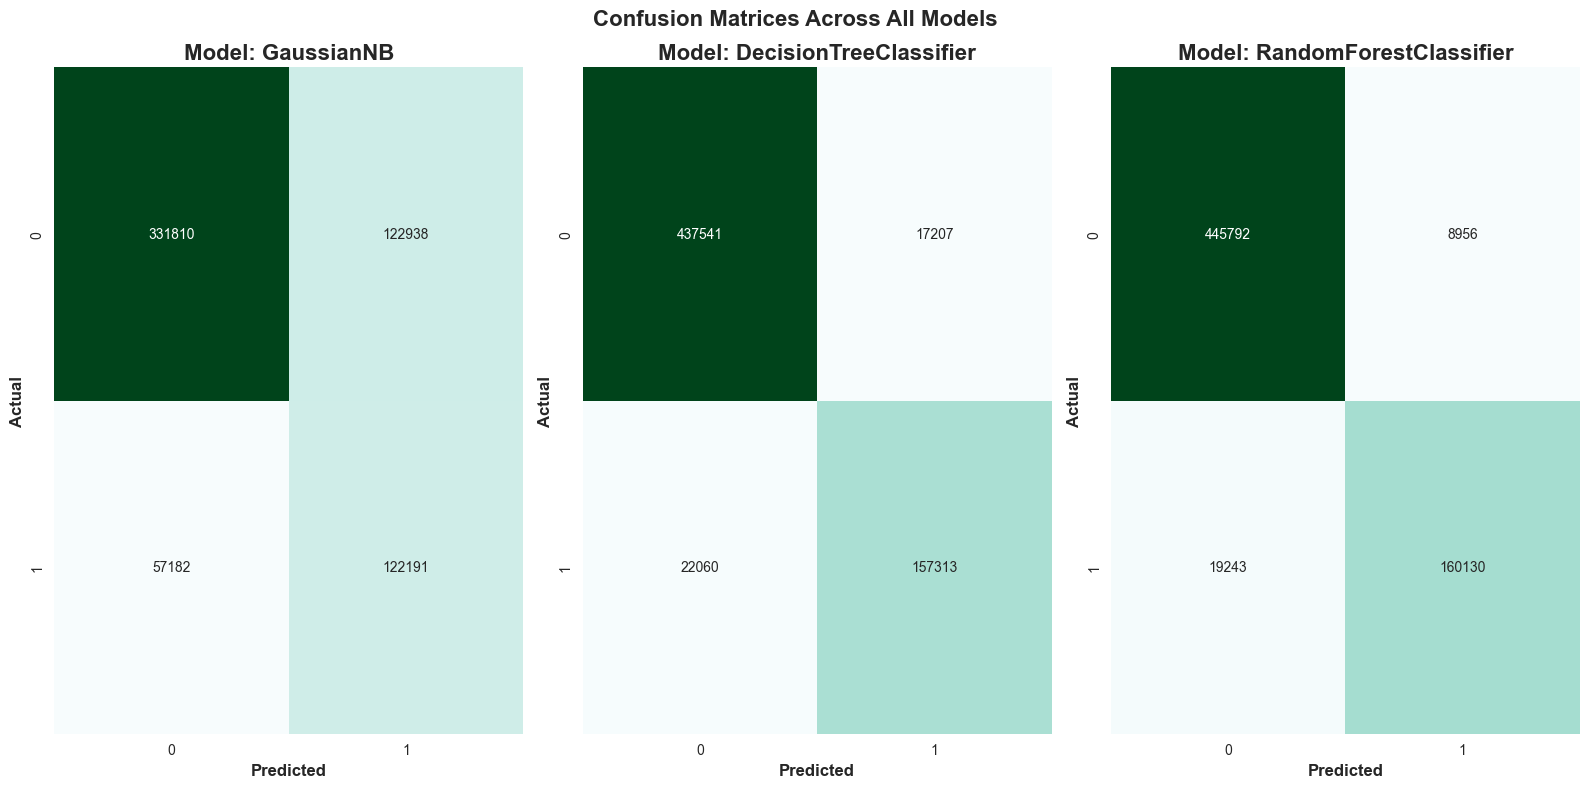

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes = axes.flatten()
classes = ["0", "1"]
for i, (name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", cbar=False,
                xticklabels=classes, yticklabels=classes, ax=axes[i])
    axes[i].set_title(f"Model: {name}", fontsize=16, fontweight="bold")
    axes[i].set_xlabel("Predicted", fontsize=12, fontweight="bold")
    axes[i].set_ylabel("Actual", fontsize=12, fontweight="bold")

plt.suptitle("Confusion Matrices Across All Models", fontsize=16, fontweight="bold")
plt.tight_layout();

We can see that **GaussianNB performs worse than the other models**, while **DecisionTreeClassifier** and **RandomForestClassifier** show noticeably better results. However, this outcome is expected, as we are evaluating the models on the full dataset — effectively predicting past events using future data, which naturally favors more complex models like trees that can memorize patterns rather than generalize.

### Top 20 most important features

In [15]:
def get_feature_names(pipeline):
    preprocessor = pipeline.named_steps["preprocessor"]
    cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_attribs)
    return np.concatenate([num_attribs, cat_features])

In [16]:
top_features = {}

for name, model in pipes.items():
    mod = model.named_steps["model"]
    if hasattr(mod, 'feature_importances_'):
        feature_names = get_feature_names(model)
        importances = mod.feature_importances_
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        top_features[name] = feature_importance.sort_values('Importance', ascending=False).head(20)
    elif hasattr(mod, "coef_"):
        importances = np.abs(mod.coef_[0])
        feature_names = get_feature_names(model)
        feature_importance = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        })
        top_features[name] = feature_importance.sort_values("Importance", ascending=False).head(20)
    elif hasattr(mod, "theta_"):
        feature_names = get_feature_names(model)
        importances = np.abs(mod.theta_[0] - mod.theta_[1])

        feature_importance = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        })
        top_features[name] = feature_importance.sort_values("Importance", ascending=False).head(20)

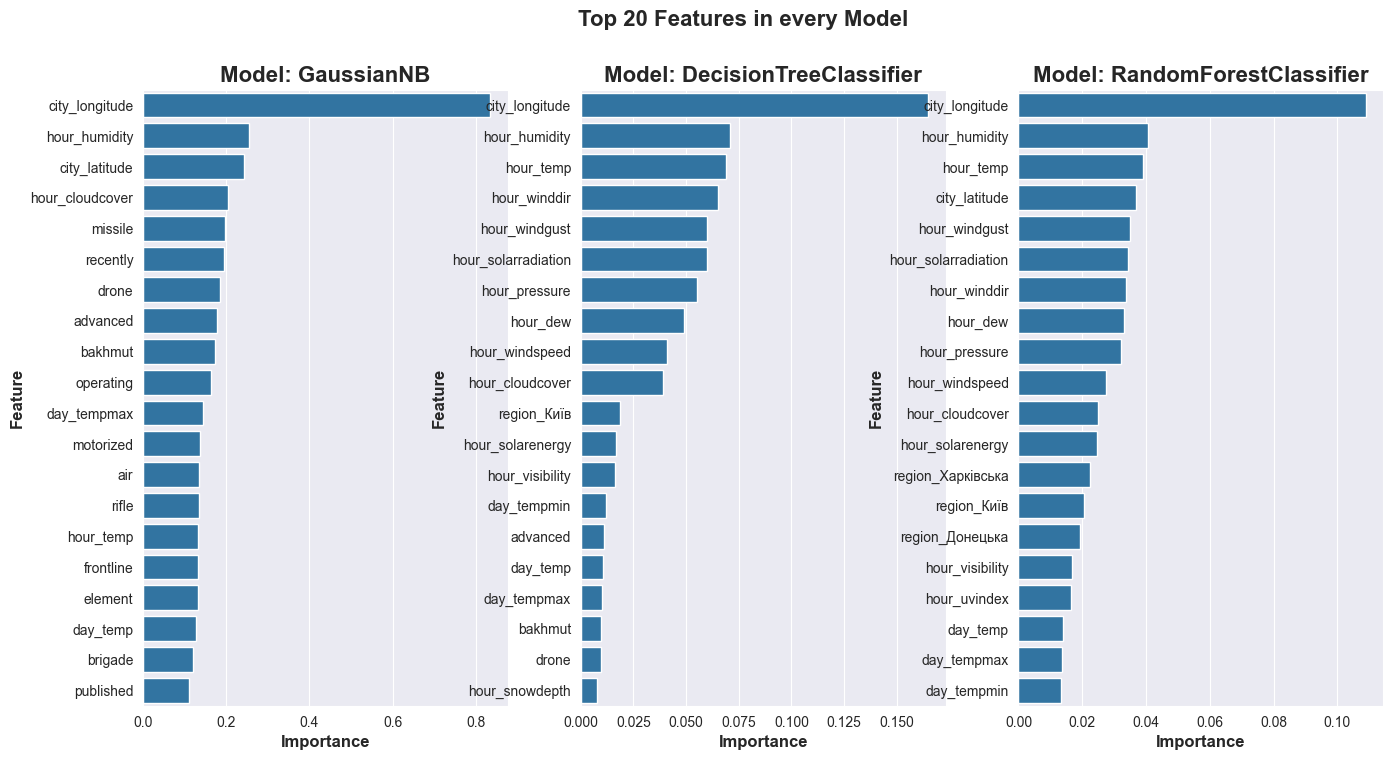

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes = axes.flatten()
classes = ["0", "1"]
for i, (name, features) in enumerate(top_features.items()):
    sns.barplot(x="Importance", y="Feature", data=features, ax=axes[i])

    axes[i].set_title(f"Model: {name}", fontsize=16, fontweight="bold")
    axes[i].set_xlabel("Importance", fontsize=12, fontweight="bold")
    axes[i].set_ylabel("Feature", fontsize=12, fontweight="bold")

plt.suptitle("Top 20 Features in every Model", fontsize=16, fontweight="bold")
plt.tight_layout;

### Key Takeaways:
- Across **all models**, city_longitude, hour_humidity, and hour_temp consistently appear at the top.
- **GaussianNB** heavily relies on just a few features, with city_longitude dominating the importance.
- **DecisionTreeClassifier** and **RandomForestClassifier** share many of the same top features.
- However, **RandomForestClassifier** presents a more balanced distribution of feature importance across the top 20 and gives relatively more weight to **regional features*.
- Notably, **ISW-related features** are rarely among the top-ranked, which **confirms our earlier assumptions** that such textual or contextual indicators have limited predictive power in this setting compared to weather data.

### Choosing the Best Model

After comparing the three models, we selected the **RandomForestClassifier** as our final model. While its performance after TimeSeriesSplit was similar to that of GaussianNB, Random Forest has the advantage of capturing more complex patterns, which can lead to more accurate predictions. Furthermore, since we applied **GridSearchCV** to optimize its hyperparameters, it is the most fine-tuned model.

Although this comparison is not entirely ideal, as it involves predicting past events, **RandomForestClassifier** delivered the best accuracy and overall scores. Therefore, we have chosen it as the model for our final predictions.

In [18]:
for name, model in pipes.items():
    y_pred = model.predict(X)
    print(name)
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Recall: {recall_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y, y_pred):.4f}")
    print("==============================")

GaussianNB
Accuracy: 0.7160
Recall: 0.6812
Precision: 0.4985
F1 Score: 0.5757
DecisionTreeClassifier
Accuracy: 0.9381
Recall: 0.8770
Precision: 0.9014
F1 Score: 0.8890
RandomForestClassifier
Accuracy: 0.9555
Recall: 0.8927
Precision: 0.9470
F1 Score: 0.9191


## Future Possible Improvements

While our current model performs decently, there are several **key opportunities** for enhancement:

### 1. **Feature Engineering**

One of the primary areas for improvement is in **feature selection and generation**. Although our model currently relies on weather and report features, there are other **potential features** that could enhance the model's performance. For example, features mentioned in the **task PDF** could provide valuable insights that are currently missing from our dataset. Experimenting with these new features could improve prediction accuracy.

We could also experiment with **dropping or adding specific columns** in the dataset, particularly those used in weather analysis. While we don't expect big changes, even **small improvements**—such as a few percentage points—can make an impact on the model's overall effectiveness.

### 2. **Model Complexity**

Our current model, **RandomForestClassifier**, performs well, but there is still room to explore more **complex models** to push performance even further. For instance, **neural networks** could be tested, particularly for their ability to model complex relationships.

### 3. **ISW Features**

Another area for improvement involves the **ISW (Institute for the Study of War) features**. We have reservations about their relevance since these features are based on daily reports, and using older reports to predict future events may not be ideal. Our findings confirm this—**ISW features were not highly influential**, as shown in the feature importance plots, and their inclusion did not lead to any significant performance gains. In fact, **training the model without the ISW features** resulted in better scores, suggesting that these features may not be contributing positively.

It might be worthwhile to revisit the **ISW features** and explore ways to use them more effectively, or possibly exclude them altogether.

### 4. **Data Sources and Telegram Chats**

Another promising improvement involves incorporating **hourly data** and exploring additional **Telegram chat sources**. Currently, we focus on weather and regional features, but integrating messages from **Telegram chats** could offer valuable context and signals about upcoming events or trends that might assist in predicting alarms.

However, this approach comes with challenges: **Telegram chats** often contain large volumes of messages, especially when tracking over extended periods. Processing such large datasets would require robust **data-cleaning** techniques and efficient **preprocessing pipelines** to ensure that the data is well-structured and meaningful for the model.

### 5. **Fun Idea: Using Tarot Accounts**

As an unconventional idea, we considered experimenting with **Tarot Telegram accounts**. These accounts often post **predictions** or insights related to future events, and it could be interesting to test how this speculative data might complement the more traditional features used in the model. Although **Tarot accounts** do not predict every alarm, their predictions could be useful in identifying general trends or potential major events.

However, this idea was not implemented due to **time constraints**, and it would require finding a reliable channel to gather the data. Additionally, we need to consider the **validity** and **accuracy** of these predictions, as they are speculative and less grounded in real-world data. Still, it could be a fun experiment to explore how **unconventional data sources** might add value to traditional prediction models.